In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.data import imread
import matplotlib.pyplot as plt
from pathlib import Path

import os

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [6]:
os.chdir("/home/atarasov/datasets/airbus_challenge/")
os.getcwd()
print(os.listdir("."))

# Any results you write to the current directory are saved as output.

['train.zip', 'train_ship_segmentations.csv.zip', 'sample_submission.csv', 'test', 'test.zip', 'sample_submission.csv.zip', 'train_ship_segmentations.csv', 'train']


In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

## Look at a sample of the training images.

In [8]:
train = pd.read_csv('train_ship_segmentations.csv')
train.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
2  00021ddc3.jpg  101361 1 102128 3 102896 4 103663 6 104430 9 1...
3  00021ddc3.jpg  95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4  00021ddc3.jpg  74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...

## Look at 25 images with ships...

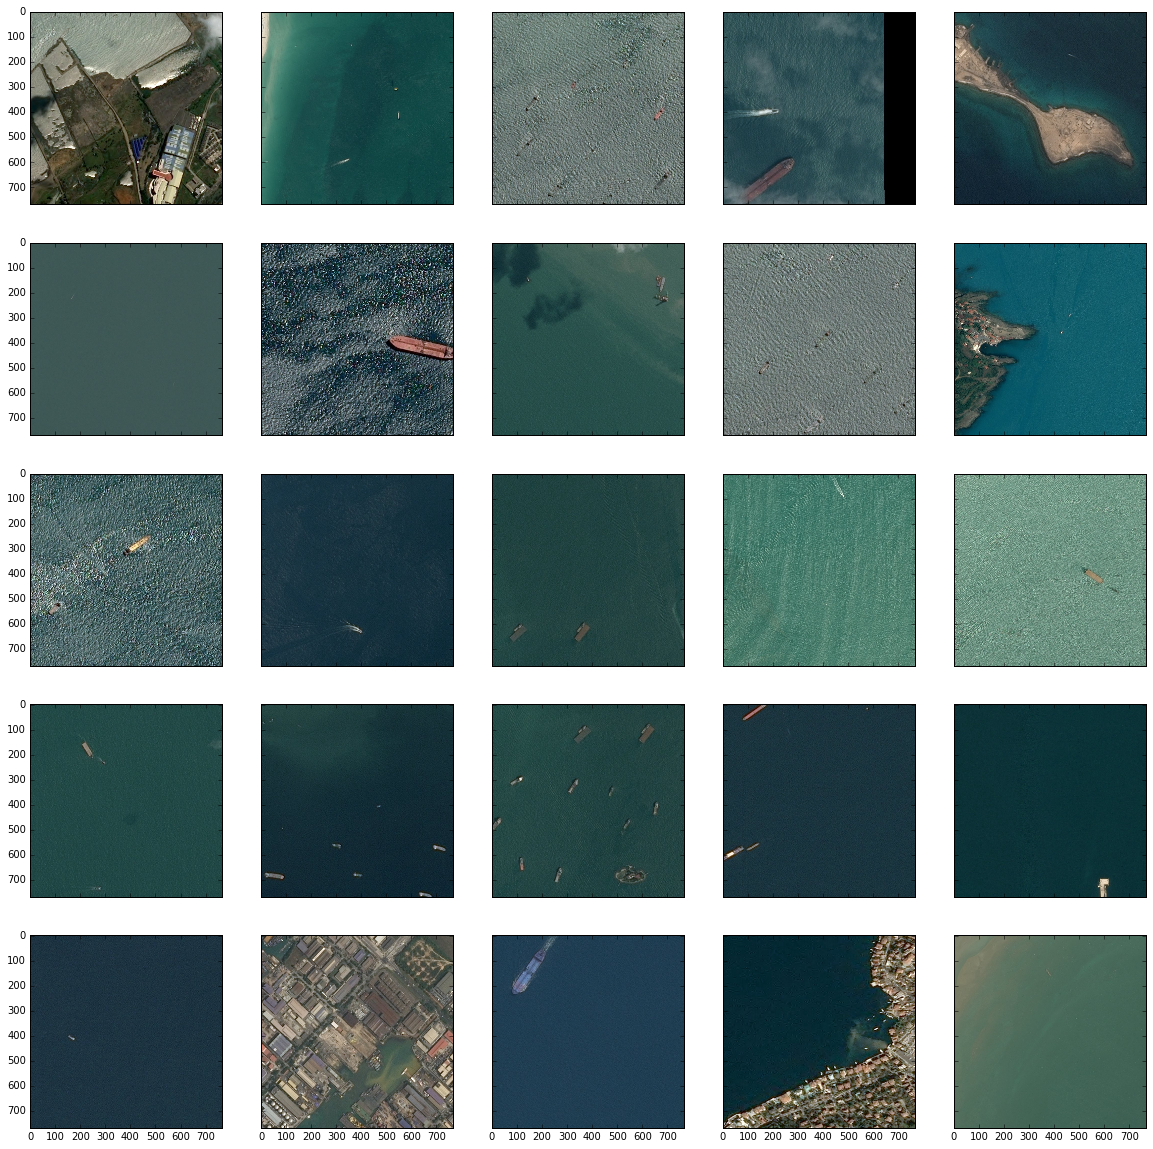

In [9]:
sample = train[~train.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path('train') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

## ...and 25 without ships.

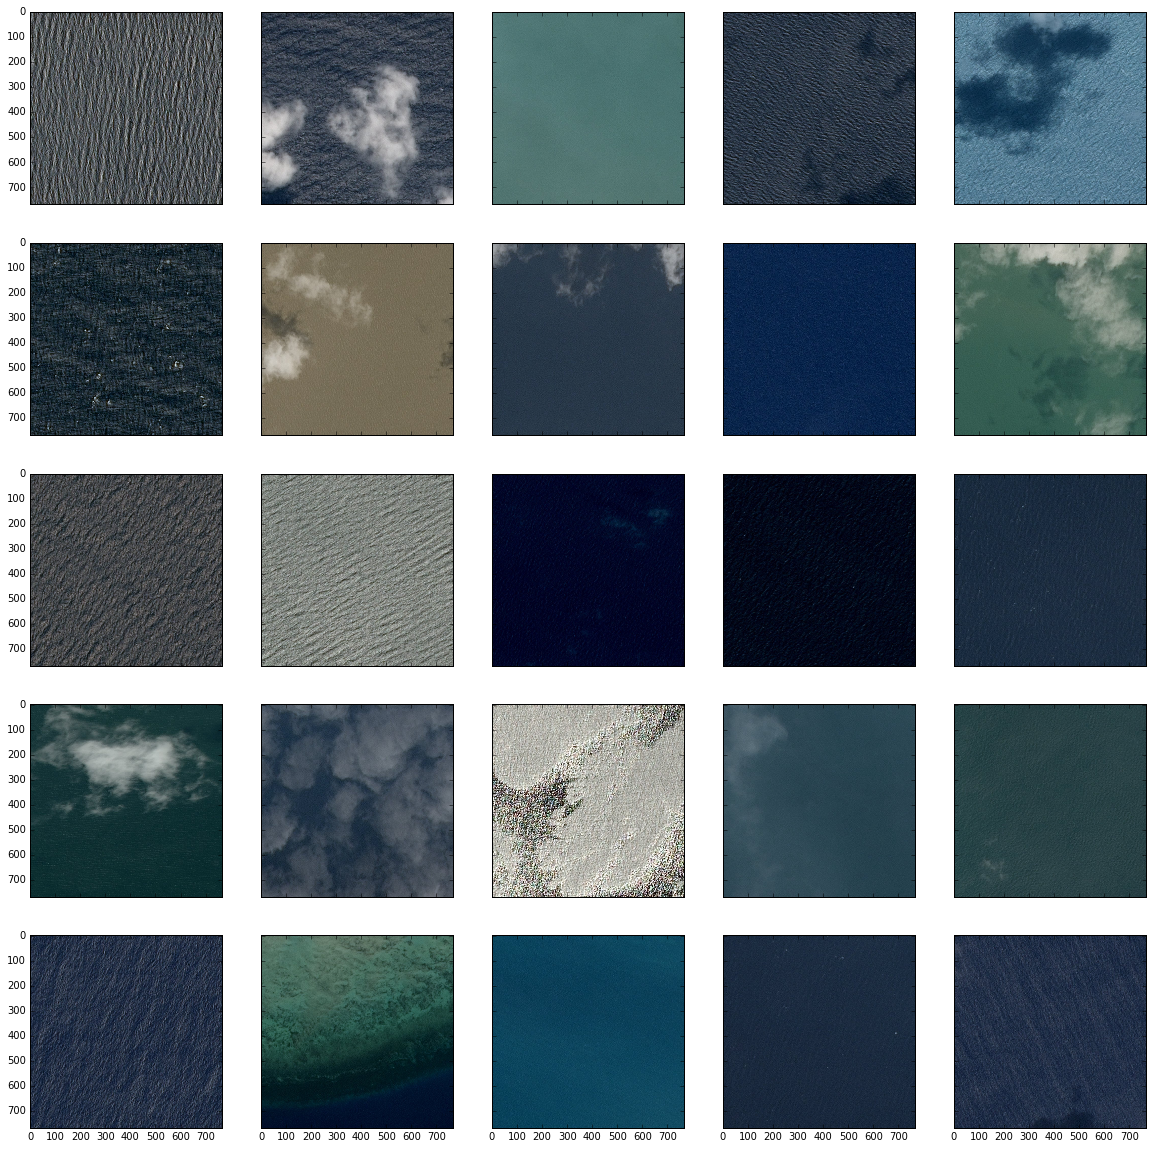

In [10]:
sample = train[train.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path('train') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

## Look at class balance

In [49]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()

labels = ['Ships', 'No Ships'] 

print(labels[0] + ":", len(ships))
print(labels[1] + ":", len(noships))

Ships: 29070
No Ships: 75000


## Look at colour distributions between images with ships and those without.

Lets look at 250 of each, sampled at random.

In [16]:
def get_img(imgid):
    '''Return image array, given ID.'''
    path = Path('train/') / '{}'.format(imgid)
    return imread(path)

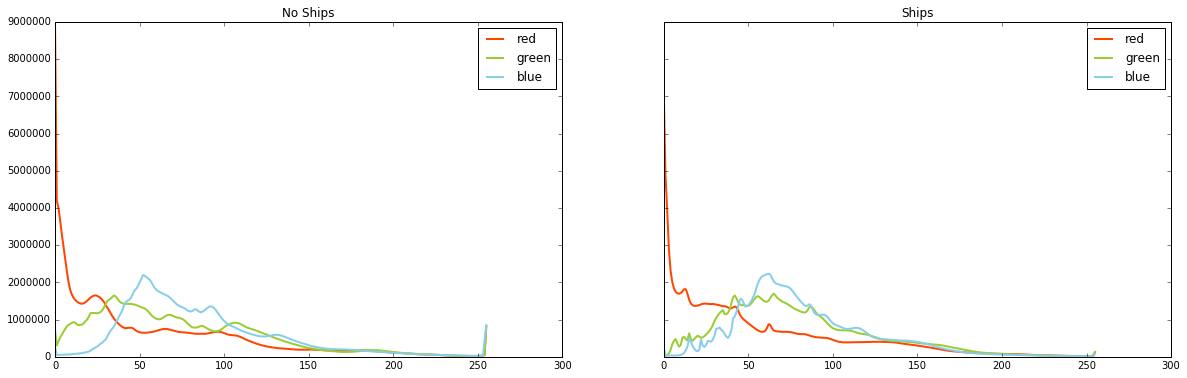

In [17]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = np.array([get_img(_id) for _id in _ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    ax[i].plot(np.bincount(red.ravel()), color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel()), color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel()), color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)

## Look at colour distributions of areas with no ships and ships themselves.

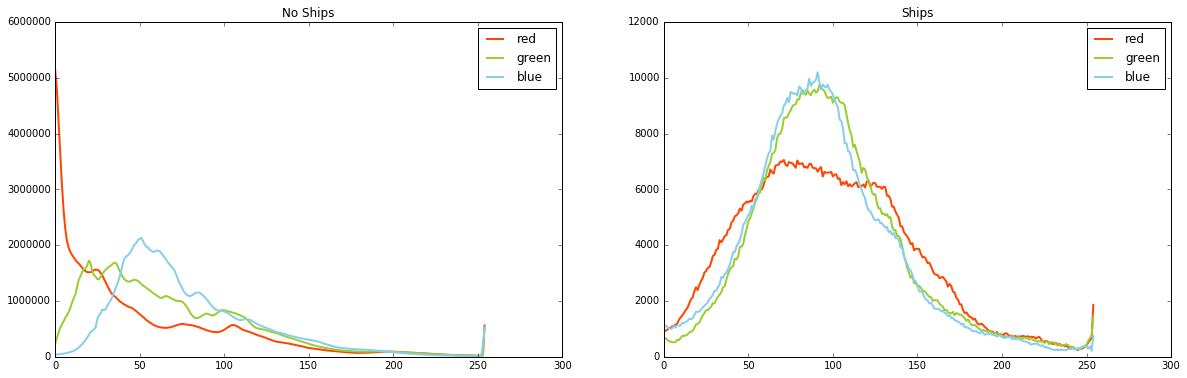

In [18]:
def apply_masks_to_img(img, _id, df):
    '''Apply masks to image given img, its id and the dataframe.'''
    masks = df[df.ImageId == _id].EncodedPixels.apply(lambda x: rle_decode(x)).tolist()
    masks = sum(masks)
    return img * masks.reshape(img.shape[0], img.shape[1], 1)


fig, ax = plt.subplots(1, 2, sharex='col')#, sharey='row')
fig.set_size_inches(20, 6)

mask = train.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train[msk].ImageId.sample(250)
    imgs = [get_img(_id) for _id in _ids]
    
    # if we have an encoding to decode
    if i == 1:
        imgs = [apply_masks_to_img(i, _id, train) for (i, _id) in zip(imgs, _ids)]

    imgs = np.array(imgs)
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    # skip bincount index 0 to avoid the masked pixels to overpower the others.
    ax[i].plot(np.bincount(red.ravel())[1:], color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel())[1:], color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel())[1:], color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)